In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
import re,string
from datetime import datetime as dt
import seaborn as sns
import nltk
from matplotlib.ticker import FuncFormatter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import json

def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [ ]:
reviw_path = "/content/drive/MyDrive/Yelp_dataset/yelp_academic_dataset_review.json"
business_path= '/content/drive/MyDrive/Yelp_dataset/yelp_academic_dataset_business.json'
final_rest_data= '/content/drive/MyDrive/Yelp_dataset/final_rest_data.csv'

In [ ]:
yelp_review= read_json(reviw_path)
yelp_review.drop(['review_id', 'user_id', 'useful', 'funny', 'cool'], axis=1, inplace=True)
yelp_review['date'] = pd.to_datetime(yelp_review['date'])

In [ ]:
yelp_business= read_json(business_path)

In [ ]:
final_rest_df= pd.read_csv(final_rest_data)
final_rest_df.drop(['Unnamed: 0', 'category'], axis=1, inplace= True)
final_rest_df.rename({'our_open': 'is_open'}, axis=1, inplace= True)

In [ ]:
#merge final_rest_df and orginal business file
final_business_tex= pd.merge(final_rest_df, yelp_business, on= 'business_id', how= 'inner')

new_cols= ['business_id','name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'attributes', 'categories', 'hours', 'is_open_x',  'age' ,'American', 'Mexican', 'Italian', 'Japanese', 'Chinese', 'Thai', 'Mediterranean', 'French', 'Vietnamese','Greek', 'Indian', 'Korean', 'Hawaiian', 'African', 'Spanish', 'Middle_eastern', 'Other']

final_business_tex= final_business_tex[new_cols]
final_business_tex.rename({'is_open_x': 'is_open', 'age': 'operation_years'}, axis=1, inplace= True)

In [ ]:
final_business_tex.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,hours,is_open,operation_years,American,Mexican,Italian,Japanese,Chinese,Thai,Mediterranean,French,Vietnamese,Greek,Indian,Korean,Hawaiian,African,Spanish,Middle_eastern,Other
0,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,78729,30.441875,-97.746581,2.0,"{'RestaurantsPriceRange2': '1', 'OutdoorSeatin...","Fast Food, Restaurants, Burgers","{'Monday': '6:30-1:0', 'Tuesday': '6:30-1:0', ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Pk4ZwXwUU50BDn5gqw_rKg,Johnny Carino's,9500 S IH-35 Service Rd,Austin,TX,78748,30.162081,-97.789132,3.0,"{'RestaurantsGoodForGroups': 'True', 'Business...","Italian, Salad, Pizza, Nightlife, Restaurants,...","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Normalize review_count and positive and negative count by age:

In [ ]:
unique_businss_id= list(final_business_tex['business_id'].unique())
len(unique_businss_id)

2883

In [ ]:
##get reviews for above business ids

review_by_business= yelp_review[yelp_review.business_id.isin(unique_businss_id)].copy()
review_by_business['date'] = pd.to_datetime(review_by_business['date'])
review_by_business.sort_values(by=['business_id','date'], inplace= True)
review_by_business.reset_index(inplace= True, drop= True)

# get reviews only between 2016-2019

review_by_business1= review_by_business[(review_by_business['date'].dt.year >= 2016) & (review_by_business['date'].dt.year < 2020)].copy()
review_by_business1.sort_values(by=['business_id','date'], inplace= True)
review_by_business1.reset_index(drop=True, inplace=True)
review_by_business1.head(3)

,business_id,stars,text,date
0,-4cQ12xutjNLW-tPI06_tg,5.0,Yummy. I love the chocolate covered donut hole...,2016-01-11 15:44:26
1,-4cQ12xutjNLW-tPI06_tg,2.0,"First the good. Great service, fast & courteou...",2016-02-01 00:19:32
2,-4cQ12xutjNLW-tPI06_tg,5.0,"OMG!!! Like the best selection of donuts, pigg...",2016-02-11 15:34:39


In [ ]:
#review count between 2016-2019
age_df= review_by_business1.groupby('business_id', as_index= False).size()

#first review date and last review date(till 2019 - so age_df1 is consisdered)

age_df_first= review_by_business.groupby('business_id', as_index= False).first().copy()
age_df_last= review_by_business1.groupby('business_id', as_index= False).last().copy()
age_df_first['Opened_year']= age_df_first['date'].dt.year
age_df_last['Last_year'] = age_df_last['date'].dt.year

#determine age of restuarant till 2019
rest_age_df= pd.merge(age_df_first, age_df_last, on='business_id', how='inner')
rest_age_df.drop(['stars_x', 'stars_y', 'date_x', 'date_y'], axis=1, inplace= True)
rest_age_df['age'] = rest_age_df['Last_year'] - rest_age_df['Opened_year']
rest_age_df['age']= rest_age_df['age'].apply(lambda x: x+1)
rest_age_df.drop(['text_x', 'Opened_year','text_y','Last_year'], axis=1, inplace= True)
rest_age_df.head(3)

,business_id,age
0,-4cQ12xutjNLW-tPI06_tg,11
1,-4ofMtrD7pSpZIX5pnDkig,15
2,-85pDrVcAdzNK55bFpintg,14


In [ ]:
#merge review count and first and last year
rest_age_df1= pd.merge(rest_age_df, age_df, on='business_id', how='inner')
rest_age_df1.rename({'size': 'review_count_16_19'}, axis=1, inplace= True)

rest_age_df1['review_normalized']= np.round( (rest_age_df1['review_count_16_19'] / rest_age_df1['age']), 2)

rest_age_df1.head(3)

,business_id,age,review_count_16_19,review_normalized
0,-4cQ12xutjNLW-tPI06_tg,11,37,3.36
1,-4ofMtrD7pSpZIX5pnDkig,15,592,39.47
2,-85pDrVcAdzNK55bFpintg,14,126,9.00


In [ ]:
#postive negative and neutral reviews
pos_rev= review_by_business1[review_by_business1['stars'] >= 4]
neg_rev= review_by_business1[review_by_business1['stars'] < 3]
neu_rev= review_by_business1[review_by_business1['stars'] == 3]

pos_rest = pos_rev.groupby(['business_id']).size()
neg_rest = neg_rev.groupby(['business_id']).size()
neu_rest = neu_rev.groupby(['business_id']).size()
result = pd.concat([pos_rest, neg_rest,neu_rest], axis=1, join= "outer", keys='business_id', ignore_index=True)
result.reset_index(inplace= True)
result.columns= ['business_id','pos', 'neg', 'neutral']
result['pos'].fillna(0, inplace= True)
result['neg'].fillna(0, inplace= True)
result['neutral'].fillna(0, inplace= True)


#create normalized colums for postive, negative and neutral no. of reviews
reviews_df_norm= pd.merge(result, rest_age_df, on='business_id', how= 'inner')
reviews_df_norm['pos_norm']= np.round( (reviews_df_norm['pos'] / reviews_df_norm['age']), 2)
reviews_df_norm['neg_norm']= np.round( (reviews_df_norm['neg'] / reviews_df_norm['age']), 2)
reviews_df_norm['neutral_norm']= np.round( (reviews_df_norm['neutral'] / reviews_df_norm['age']), 2)

In [ ]:
fin_df= pd.merge(rest_age_df1, reviews_df_norm, on='business_id', how='inner')

fin_df.drop(['age_y'], axis=1, inplace= True)
fin_df.rename({'age_x': 'age'}, axis=1, inplace= True)
rev_cnt_df= pd.merge(final_business_tex, fin_df, on='business_id', how= 'inner')

rev_cnt_df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,hours,is_open,operation_years,American,Mexican,Italian,Japanese,Chinese,Thai,Mediterranean,French,Vietnamese,Greek,Indian,Korean,Hawaiian,African,Spanish,Middle_eastern,Other,age,review_count_16_19,review_normalized,pos,neg,neutral,pos_norm,neg_norm,neutral_norm
0,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,78729,30.441875,-97.746581,2.0,"{'RestaurantsPriceRange2': '1', 'OutdoorSeatin...","Fast Food, Restaurants, Burgers","{'Monday': '6:30-1:0', 'Tuesday': '6:30-1:0', ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,34,4.25,6.0,27.0,1.0,0.75,3.38,0.12
1,Pk4ZwXwUU50BDn5gqw_rKg,Johnny Carino's,9500 S IH-35 Service Rd,Austin,TX,78748,30.162081,-97.789132,3.0,"{'RestaurantsGoodForGroups': 'True', 'Business...","Italian, Salad, Pizza, Nightlife, Restaurants,...","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,68,5.67,25.0,33.0,10.0,2.08,2.75,0.83
2,m_a0-8_wR1ypvZzDGeSIgA,Wingstop,"5167 Kyle Center Dr, Ste 114",Kyle,TX,78640,30.013465,-97.863625,2.5,"{'Ambience': '{'touristy': False, 'hipster': F...","Restaurants, Chicken Wings","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,27,6.75,12.0,12.0,3.0,3.00,3.00,0.75


In [ ]:
del final_business_tex, fin_df, reviews_df_norm, pos_rev, neg_rev, neu_rev, pos_rest, neg_rest, neu_rest, rest_age_df, rest_age_df1, result, review_by_business

### Using top bigram features and generating: text based feature
Frequency of occurence of bigram words about food, location, service etc in reviews.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#merge all reviews for a particular business id
review_by_business2 = pd.DataFrame(review_by_business1.groupby(['business_id'])['text'].agg(lambda col: ' '.join(col)).reset_index())

In [ ]:
#declare stop words
my_stopwords= set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + ['youll', 'ive', 'got', 'im'])
words_to_remove_from_stopwords= ['no' , 'not', 'don', "don't", "didn't", "won't", "wouldn", "wouldn't", "isn't" , 'least' 'never']
my_stopwords = [ word for word in my_stopwords if word not in words_to_remove_from_stopwords]

#convert reviews to lower case
review_by_business2['review_lowercase']= review_by_business2['text'].str.lower()

In [ ]:
#stop words removal and punctuation removal 
review_by_business2['review_nopunc_num']= review_by_business2['review_lowercase'].str.replace('[^\w\s]', '')
review_by_business2['review_nopunc_num']= review_by_business2['review_nopunc_num'].apply(lambda x: re.sub(r'[0-9]', '', x))

#remove stopwords
review_by_business2['clean_text']= review_by_business2['review_nopunc_num'].apply(lambda x: " ".join(x for x in x.split() if x not in my_stopwords))
review_by_business2.drop(['text', 'review_lowercase', 'review_nopunc_num'], axis=1, inplace= True)

In [ ]:
# Lemmatize cleaned text (stem words)
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
review_by_business2['tokenized_review'] = review_by_business2['clean_text'].apply(lambda x: w_tokenizer.tokenize(x))
#porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
review_by_business2['lemma_text'] = review_by_business2['tokenized_review'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
review_by_business2['lemma_text'] = review_by_business2['lemma_text'].apply(lambda x: ' '.join(x))
review_by_business2.drop(['tokenized_review', 'clean_text'], axis=1, inplace= True)
review_by_business2.head(3)

,business_id,lemma_text
0,-4cQ12xutjNLW-tPI06_tg,yummy love chocolate covered donut hole mexica...
1,-4ofMtrD7pSpZIX5pnDkig,cute little coffee shop colorado river busy wa...
2,-85pDrVcAdzNK55bFpintg,nope high hope waited minute menu place order ...


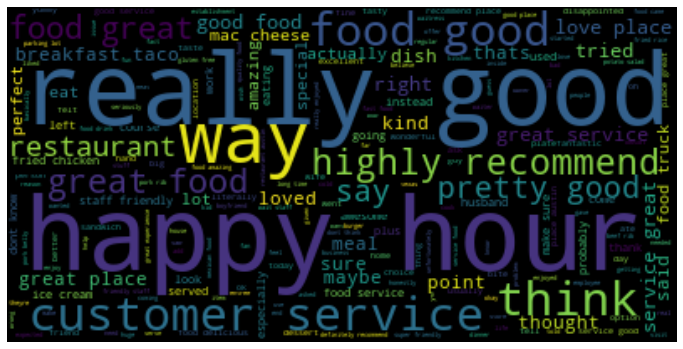

In [ ]:
#to plot wordcloud

full_text = ' '.join(review_by_business2['lemma_text'])
wordcloud = WordCloud().generate(full_text)
plt.figure( figsize=(12,12) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
vect = CountVectorizer(stop_words=my_stopwords, ngram_range=(2,2), min_df= 20)
bigrams = vect.fit_transform(review_by_business2['lemma_text'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False)

<BarContainer object of 30 artists>

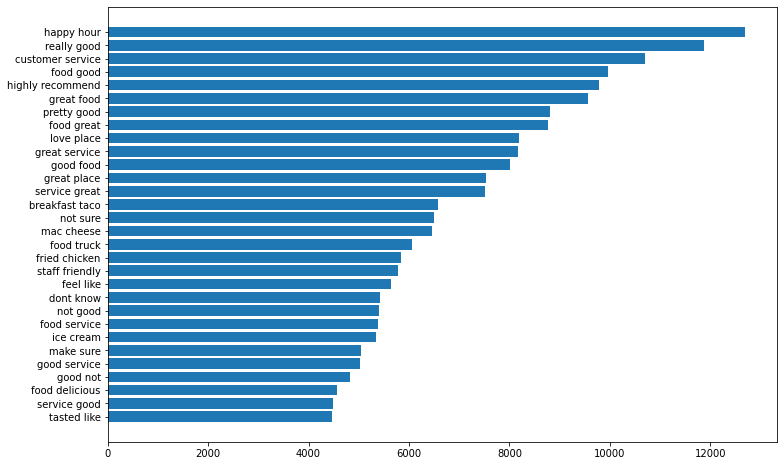

In [ ]:
bigram_frequency1 = bigram_frequency.head(30).copy()
bigram_frequency1.sort_values(['frequency'], ascending= True, inplace=True)
fig, ax = plt.subplots()

# Fig size
fig.set_size_inches(12,8)
plt.barh(y=bigram_frequency1['bigram'], width=bigram_frequency1['frequency'])

In [ ]:
good_bigram_foodtext= ['really good', 'food good', 'pretty good', 'great food', 'good food', 'happy hour', 'food delicious']
good_bigram_loc_text= ['love place', 'great service', 'great place', 'service great', 'good service', 'service good']
bad_bigram_text= ['not good', 'not great', 'not worth', 'waited minute', 'long time']

In [ ]:
df= review_by_business2.copy()
x= 0*df.shape[0]
for p in good_bigram_foodtext:
    x= x+ df['lemma_text'].str.count(p)
df['bi_goodfood_text'] = x

x= 0*df.shape[0]
for p in good_bigram_loc_text:
    x= x+ df['lemma_text'].str.count(p)
df['bi_goodloc_text'] = x


x= 0*df.shape[0]
for p in bad_bigram_text:
    x= x+ df['lemma_text'].str.count(p)
df['bi_bad_text'] = x

df.drop(['lemma_text'], axis=1, inplace= True)

df.head(3)

,business_id,bi_goodfood_text,bi_goodloc_text,bi_bad_text
0,-4cQ12xutjNLW-tPI06_tg,3,5,6
1,-4ofMtrD7pSpZIX5pnDkig,53,100,35
2,-85pDrVcAdzNK55bFpintg,28,12,6


In [ ]:
#merge business dataset with bigram_feature dataset and save 
nlp_df= pd.merge(rev_cnt_df, df, on='business_id', how= 'inner')

In [ ]:
del rev_cnt_df, df, bigrams, bigram_frequency1, bigram_frequency1, vect, full_text, wordcloud, review_by_business2, review_by_business1

### Attributes

In [ ]:
nlp_df1= nlp_df.copy()

In [ ]:
def extract_attr(y, feature, target_col=None):
    val= None
    if y:
        if target_col:
            attr=y.get(feature)
            attr = None if attr == 'None' else attr
            if attr:
                val= (eval(attr).get(target_col))
        else:
            val= y.get(feature)
    return val

In [ ]:
nlp_df.loc[:,'Delivery']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'RestaurantsDelivery'), axis=1)
nlp_df.loc[:,'ByAppointmentOnly']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'ByAppointmentOnly'), axis=1)
nlp_df.loc[:,'RestaurantsPriceRange2']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'RestaurantsPriceRange2'), axis=1)
nlp_df.loc[:,'Alcohol']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Alcohol'), axis=1)
nlp_df.loc[:,'OutdoorSeating']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'OutdoorSeating'), axis=1)
nlp_df.loc[:,'HasTV']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'OutdoorSeating'), axis=1)

nlp_df.loc[:,'Touristy']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'touristy'), axis=1)
nlp_df.loc[:,'Hipster']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'hipster'), axis=1)
nlp_df.loc[:,'Romantic']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'romantic'), axis=1)
nlp_df.loc[:,'Divey']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'divey'), axis=1)
nlp_df.loc[:,'Intimate']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'intimate'), axis=1)
nlp_df.loc[:,'Trendy']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'trendy'), axis=1)
nlp_df.loc[:,'Upscale']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'upscale' ), axis=1)
nlp_df.loc[:,'Classy']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'classy'), axis=1)
nlp_df.loc[:,'Casual']= nlp_df.apply(lambda row: extract_attr(row['attributes'],  'Ambience', 'casual'), axis=1)

In [ ]:
nlp_df['Delivery'] = nlp_df['Delivery'].map({'True':True ,'False':False, 'None': np.nan})
nlp_df['ByAppointmentOnly'] = nlp_df['ByAppointmentOnly'].map({'True':True ,'False':False, 'None': np.nan})
nlp_df['RestaurantsPriceRange2'] = nlp_df['RestaurantsPriceRange2'].map({'1':1 ,'2':2, '3': 3, '4': 4, 'None': np.nan})
nlp_df['OutdoorSeating'] = nlp_df['OutdoorSeating'].map({'True':True ,'False':False, 'None': np.nan})
nlp_df['HasTV'] = nlp_df['HasTV'].map({'True':True ,'False':False, 'None': np.nan})
nlp_df['Alcohol'] = nlp_df['Alcohol'].map({"u'full_bar'":'full_bar' , "u'beer_and_wine'": 'beer_and_wine', "'beer_and_wine'" : 'beer_and_wine', "'full_bar'": 'full_bar', "u'none":np.nan, "'none'": np.nan, 'None': np.nan})


##### Check for NA counts and impute where necessary

In [ ]:
def check_na_counts(column):
    f= nlp_df[column].value_counts(dropna= False)
    ind= f.index
    val_cnt_dict={}
    for i,v in enumerate(f):
        val_cnt_dict[str(ind[i])] = v

    return val_cnt_dict

In [ ]:
cols= ['Delivery', 'ByAppointmentOnly' ,'RestaurantsPriceRange2', 'OutdoorSeating', 'HasTV' , 'Alcohol', 'OutdoorSeating', 'HasTV', 'Touristy', 'Hipster', 'Romantic', 'Divey', 'Intimate', 'Trendy', 'Upscale', 'Classy', 'Casual']

In [ ]:
dict_val_count={}
for i in cols:
    val_cnt_dict= check_na_counts(i)
    dict_val_count[i]= (val_cnt_dict)

In [ ]:
dict_val_count

{'Alcohol': {'beer_and_wine': 597, 'full_bar': 761, 'nan': 1525},
 'ByAppointmentOnly': {'False': 398, 'True': 16, 'nan': 2469},
 'Casual': {'False': 812, 'True': 1730, 'nan': 341},
 'Classy': {'False': 2011, 'True': 523, 'nan': 349},
 'Delivery': {'False': 1001, 'True': 1610, 'nan': 272},
 'Divey': {'False': 2309, 'True': 99, 'nan': 475},
 'HasTV': {'False': 961, 'True': 1537, 'nan': 385},
 'Hipster': {'False': 2346, 'True': 102, 'nan': 435},
 'Intimate': {'False': 2484, 'True': 24, 'nan': 375},
 'OutdoorSeating': {'False': 961, 'True': 1537, 'nan': 385},
 'RestaurantsPriceRange2': {'1.0': 1567,
  '2.0': 1168,
  '3.0': 77,
  '4.0': 14,
  'nan': 57},
 'Romantic': {'False': 2501, 'True': 28, 'nan': 354},
 'Touristy': {'False': 2519, 'True': 6, 'nan': 358},
 'Trendy': {'False': 2274, 'True': 161, 'nan': 448},
 'Upscale': {'False': 2520, 'True': 29, 'nan': 334}}

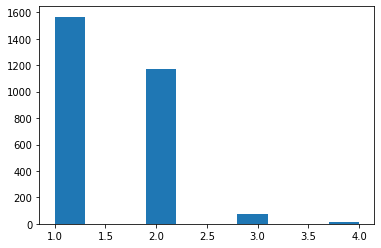

In [ ]:
### Since, most of the columns above are boolean, we can fill the na values with zero with some exceptions. 
### ByAppointmentOnly has large no of NaN values. Hence, we can remove this column as any insight caught from this column won't be relevant.
### RestaurantsPriceRange2 is a numeric column and has only 57 missing values. So we would impute this column as follows: 

# perform imputation: for RestaurantsPriceRange2 consider mode: Since, its a categorized value and also skewed distribution. We will fill the NA with mode of the distribution i.e 1
plt.hist(nlp_df['RestaurantsPriceRange2'])
plt.show()

In [ ]:
#Drop ByAppointmentOnly column and fill NA column:
nlp_df.drop(['ByAppointmentOnly', 'categories', 'attributes'], axis=1, inplace = True)

nlp_df['Delivery'].fillna(0, inplace=True)
nlp_df['RestaurantsPriceRange2'].fillna(1, inplace=True) #filled with mode value
nlp_df['OutdoorSeating'].fillna(0, inplace=True)
nlp_df['HasTV'].fillna(0, inplace=True)

nlp_df['Touristy'].fillna(0, inplace=True)
nlp_df['Hipster'].fillna(0, inplace=True)
nlp_df['Romantic'].fillna(0, inplace=True)
nlp_df['Divey'].fillna(0, inplace=True)
nlp_df['Intimate'].fillna(0, inplace=True)
nlp_df['Trendy'].fillna(0, inplace=True)
nlp_df['Upscale'].fillna(0, inplace=True)
nlp_df['Classy'].fillna(0, inplace=True)
nlp_df['Casual'].fillna(0, inplace=True)
nlp_df['Alcohol'].fillna('None_served', inplace=True)

In [ ]:
 alc_onehot= pd.get_dummies(nlp_df['Alcohol'], prefix='Alc')

In [ ]:
attr_df= pd.concat([nlp_df, alc_onehot], axis=1)
attr_df.drop(['Alcohol'], axis=1, inplace= True)

In [ ]:
# change column data type
cols= {'Delivery': 'int',  'RestaurantsPriceRange2': 'int',  'OutdoorSeating': 'int',  'HasTV': 'int',  'Touristy': 'int',  'Hipster': 'int',  'Romantic': 'int',  'Divey': 'int',  'Intimate': 'int',  'Trendy': 'int',  'Upscale': 'int',  'Classy': 'int',  'Casual' : 'int'}

attr_df= attr_df.astype(cols)

### Create open hours by breakfast, lunch and dinner

In [ ]:
def convert_datetime_to_date(string_list):
    stringlist_temp= []
    for i in string_list:
        stringlist_temp.append(dt.strptime(i, "%H:%M"))
    return stringlist_temp

In [ ]:
breakfast= ['05:00', '10:00']
lunch= ['11:00', '16:00']
dinner= ['17:00', '23:59']
#late_night= ['23:01', '0:0']

breakfast= convert_datetime_to_date(breakfast)
lunch= convert_datetime_to_date(lunch)
dinner= convert_datetime_to_date(dinner)

In [ ]:
f= attr_df.iloc[1]['hours']
print(f)

{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:30', 'Wednesday': '11:0-21:30', 'Thursday': '11:0-22:0', 'Friday': '11:0-22:30', 'Saturday': '11:0-22:30', 'Sunday': '11:0-21:30'}


#### Check if open hours not mentioned: then displayed_open_hours =0 , or if open hours mentioned but as 0:0 - 0:0 then displayed_open_hours=0 else displayed_open_hours = 1

In [ ]:
def create_open_hours(x):
    breakfast_list=0
    lunch_list=0
    dinner_list=0
    displayed_open_hours= 0
    if x!= None:
        open_hours= list(x.keys())
        for i in open_hours:
            time_str= x.get(i).split('-')
            start= time_str[0]
            end= time_str[1]
            if (start in ["0:0", "00:0"]) and (end  in ["0:0", "00:0"]):
                if open_hours.index(i) >= 3:  #breaking as if resturant doesnt display open hours for 3 days we no longer want to continue searching adn assume they have not displyed.
                    break
                continue
            else:
                if end == "0:0":
                    end= dt.strptime("23:59", "%H:%M")
                else:
                    end= dt.strptime(end, "%H:%M")
                    
                displayed_open_hours= 1
                start= dt.strptime(start, "%H:%M")
                
                if (start >= breakfast[0] and start <= breakfast[1]) | ( end >= breakfast[0] and end <= breakfast[1]):
                    breakfast_list= 1
                if (start >= lunch[0] and start <= lunch[1]) | ( end >= lunch[0] and end <= lunch[1]):
                    lunch_list= 1
                if (start >= breakfast[0] and start <= breakfast[1]) and (end >= dinner[0] and end <= dinner[1]):
                    lunch_list=1
                if (start >= dinner[0] and start <= dinner[1]) | (end >= dinner[0] and end <= dinner[1]):
                    dinner_list=1
                if (start >= lunch[0] and start <= lunch[1]) and (end >= dinner[0] and end <= dinner[1]):
                    dinner_list=1
                break

        return [[breakfast_list, lunch_list, dinner_list], displayed_open_hours]
    else:
        return [ [0, 0, 0], 0]

In [ ]:
attr_df['open_hours']= attr_df['hours'].apply(lambda x: create_open_hours(x))

In [ ]:
#Create 5 fields: 
#### open hours meals: 1: if open only for (breakfast/lunch/dinner)
####                   2: if open for both time (B+L , L+D, B+D)
####                   3: if open for all three (B+L+D)
####                   0: None

#### open_breakfast: 1/0
#### open_lunch: 1/0
#### open_dinner: 1/0

#### Displayed_open_hours : if open hours is mentioned on the website or not.

attr_df['open_breakfast']= attr_df['open_hours'].apply(lambda x: x[0][0])
attr_df['open_lunch']= attr_df['open_hours'].apply(lambda x: x[0][1])
attr_df['open_dinner']= attr_df['open_hours'].apply(lambda x: x[0][2])
attr_df['open_hours_meals']= attr_df['open_hours'].apply(lambda x: sum(x[0]))
attr_df['displayed_open_hours']= attr_df['open_hours'].apply(lambda x: x[1])

attr_df.drop(['hours', 'open_hours' ], axis=1, inplace= True)

In [ ]:
attr_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,is_open,operation_years,American,Mexican,Italian,Japanese,Chinese,Thai,Mediterranean,French,Vietnamese,Greek,Indian,Korean,Hawaiian,African,Spanish,Middle_eastern,Other,age,review_count_16_19,review_normalized,pos,neg,neutral,pos_norm,neg_norm,neutral_norm,bi_goodfood_text,bi_goodloc_text,bi_bad_text,Delivery,RestaurantsPriceRange2,OutdoorSeating,HasTV,Touristy,Hipster,Romantic,Divey,Intimate,Trendy,Upscale,Classy,Casual,Alc_None_served,Alc_beer_and_wine,Alc_full_bar,open_breakfast,open_lunch,open_dinner,open_hours_meals,displayed_open_hours
0,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,78729,30.441875,-97.746581,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,34,4.25,6.0,27.0,1.0,0.75,3.38,0.12,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1
1,Pk4ZwXwUU50BDn5gqw_rKg,Johnny Carino's,9500 S IH-35 Service Rd,Austin,TX,78748,30.162081,-97.789132,3.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,68,5.67,25.0,33.0,10.0,2.08,2.75,0.83,16,12,6,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,2,1


#### Saving dataset:

In [ ]:
attr_df.to_csv('attributes_df.csv')

#### Plot of attributes vs closure:

Ambience:

In [ ]:
size_of_attr= {'Touristy': attr_df.groupby('Touristy').size()[1], 'Hipster': attr_df.groupby('Hipster').size()[1], 'Romantic': attr_df.groupby('Romantic').size()[1] , 
    'Divey': attr_df.groupby('Divey').size()[1] ,  'Intimate': attr_df.groupby('Intimate').size()[1] , 'Trendy': attr_df.groupby('Trendy').size()[1] , 
   'Upscale': attr_df.groupby('Upscale').size()[1] , 'Classy': attr_df.groupby('Classy').size()[1] , 'Casual': attr_df.groupby('Casual').size()[1] }

Text(0.5, 1.0, 'Distribution of ambience of restaurants')

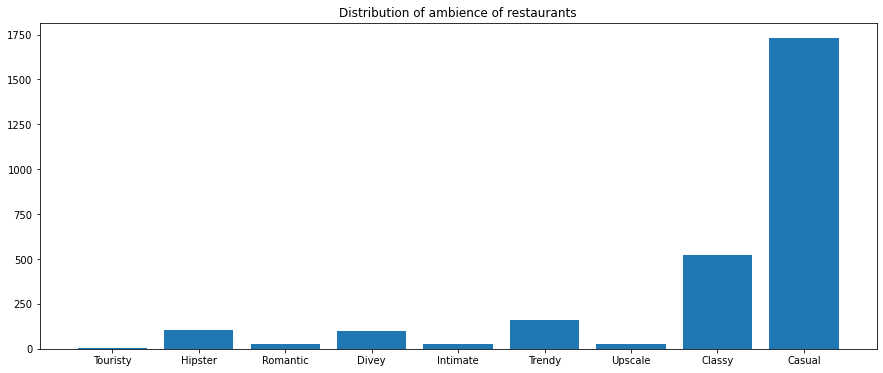

In [ ]:
names = list(size_of_attr.keys())
values = list(size_of_attr.values())
plt.gcf().set_size_inches(15, 6)
plt.bar(range(len(size_of_attr)), values, tick_label= names)

plt.title('Distribution of ambience of restaurants')

In [ ]:
cols= ['Touristy',  'Hipster',  'Romantic',  'Divey',  'Intimate',  'Trendy',  'Upscale',  'Classy',  'Casual' ]

In [ ]:
def ambience_open_val_counts(column):
    f= attr_df.groupby([column, 'is_open']).size()[1]
    ind= f.index
    val_cnt_dict={}
    for i,v in enumerate(f):
        if i == 0:
            i='close'
        else:
            i='open'
        val_cnt_dict[i] = v

    return val_cnt_dict

In [ ]:
dict_val_count={}
for i in cols:
    val_cnt_dict= ambience_open_val_counts(i)
    dict_val_count[i]= (val_cnt_dict)

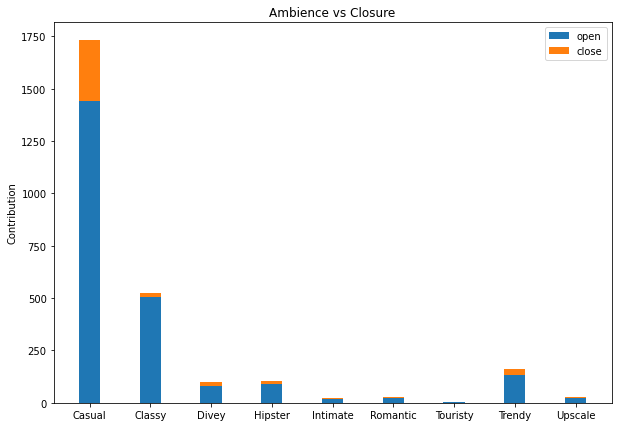

In [ ]:
N = 9
open= (dict_val_count['Casual']['open'] , dict_val_count['Classy']['open'], dict_val_count['Divey']['open'], dict_val_count['Hipster']['open'], dict_val_count['Intimate']['open'], dict_val_count['Romantic']['open'], dict_val_count['Touristy']['open'], dict_val_count['Trendy']['open'], dict_val_count['Upscale']['open'])
close= (dict_val_count['Casual']['close'] , dict_val_count['Classy']['close'], dict_val_count['Divey']['close'], dict_val_count['Hipster']['close'], dict_val_count['Intimate']['close'], dict_val_count['Romantic']['close'], dict_val_count['Touristy']['close'], dict_val_count['Trendy']['close'], dict_val_count['Upscale']['close'])

ind = np.arange(N)  
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, open, width ) #, yerr = boyStd)
p2 = plt.bar(ind, close, width, bottom = open ) #, yerr = girlStd)
 
plt.ylabel('Contribution')
plt.title('Ambience vs Closure')
plt.xticks(ind, ('Casual', 'Classy', 'Divey', 'Hipster', 'Intimate', 'Romantic', 'Touristy', 'Trendy', 'Upscale'))
plt.legend((p1[0], p2[0]), ('open', 'close'))
 
plt.show()

Price Range vs Closure:

In [ ]:
dict_val_count={}
for j in [1,2,3,4]:
    price_df= attr_df[attr_df['RestaurantsPriceRange2']==j]
    f= price_df.groupby(['is_open']).size()
    ind= f.index
    val_cnt_dict={}
    for i,v in enumerate(f):
        if i == 0:
            i='close'
        else:
            i='open'
        val_cnt_dict[i] = v
    dict_val_count[j]= (val_cnt_dict)

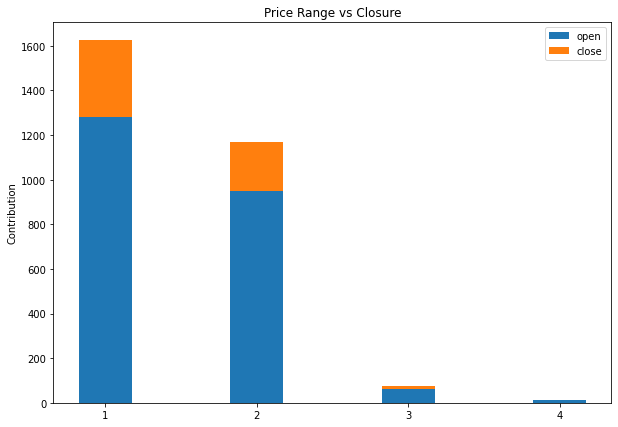

In [ ]:
#plot bar plot

N = 4
open= (dict_val_count[1]['open'], dict_val_count[2]['open'], dict_val_count[3]['open'], dict_val_count[4]['open'])
close= (dict_val_count[1]['close'], dict_val_count[2]['close'], dict_val_count[3]['close'], dict_val_count[4]['close'])

ind = np.arange(N)  
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, open, width ) #, yerr = boyStd)
p2 = plt.bar(ind, close, width, bottom = open ) #, yerr = girlStd)
 
plt.ylabel('Contribution')
plt.title('Price Range vs Closure')
plt.xticks(ind, ('1', '2', '3', '4'))
plt.legend((p1[0], p2[0]), ('open', 'close'))
 
plt.show()